# Data Preparation

## Libraries

### We will start by installing the library to download the images

In [1]:
!pip install -q openimages


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


### We must also make sure we have the right version of opencv

In [2]:
!pip uninstall -qy opencv-python
!pip install -q opencv-python-headless #version meant to be used in a containerized environment


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Dataset

We will now download the dataset for 3 classes: Bicyle, Car, and Trafic sign. We are only downloading 300 images per class to limit the processing time in this example. However, to achieve a robust YOLOv5 model, it is recommended to train with over 1500 images per class, and more then 10,000 instances per class.

We specify the darknet format (–format darknet), which is the format YOLO can handle. This will create folders for each class, in which we will have darknet and images folders.

In [3]:
labels = 'Fedora'
limit = 1500
!oi_download_dataset --base_dir download --csv_dir download --labels {labels} --format darknet --limit {limit}

2023-11-21  15:30:10 INFO Downloading 1500 train images for class 'fedora'
100%|███████████████████████████████████████| 1500/1500 [00:40<00:00, 37.18it/s]
2023-11-21  15:30:50 INFO Creating 1500 train annotations (darknet) for class 'fedora'
100%|█████████████████████████████████████| 1500/1500 [00:00<00:00, 2742.14it/s]


### Let's have a look at a sample image.

In [4]:
import os
import random
from PIL import Image, ImageDraw

def show_bbox(image_path):
    # convert image path to label path
    label_path = image_path.replace('/images/', '/darknet/')
    label_path = label_path.replace('.jpg', '.txt')

    # Open the image and create ImageDraw object for drawing
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    with open(label_path, 'r') as f:
        for line in f.readlines():
            # Split the line into five values
            label, x, y, w, h = line.split(' ')

            # Convert string into float
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)

            # Convert center position, width, height into
            # top-left and bottom-right coordinates
            W, H = image.size
            x1 = (x - w/2) * W
            y1 = (y - h/2) * H
            x2 = (x + w/2) * W
            y2 = (y + h/2) * H

            # Draw the bounding box with red lines
            draw.rectangle((x1, y1, x2, y2),
                           outline=255, # Red in RGB
                           width=5)             # Line width
    image.show()

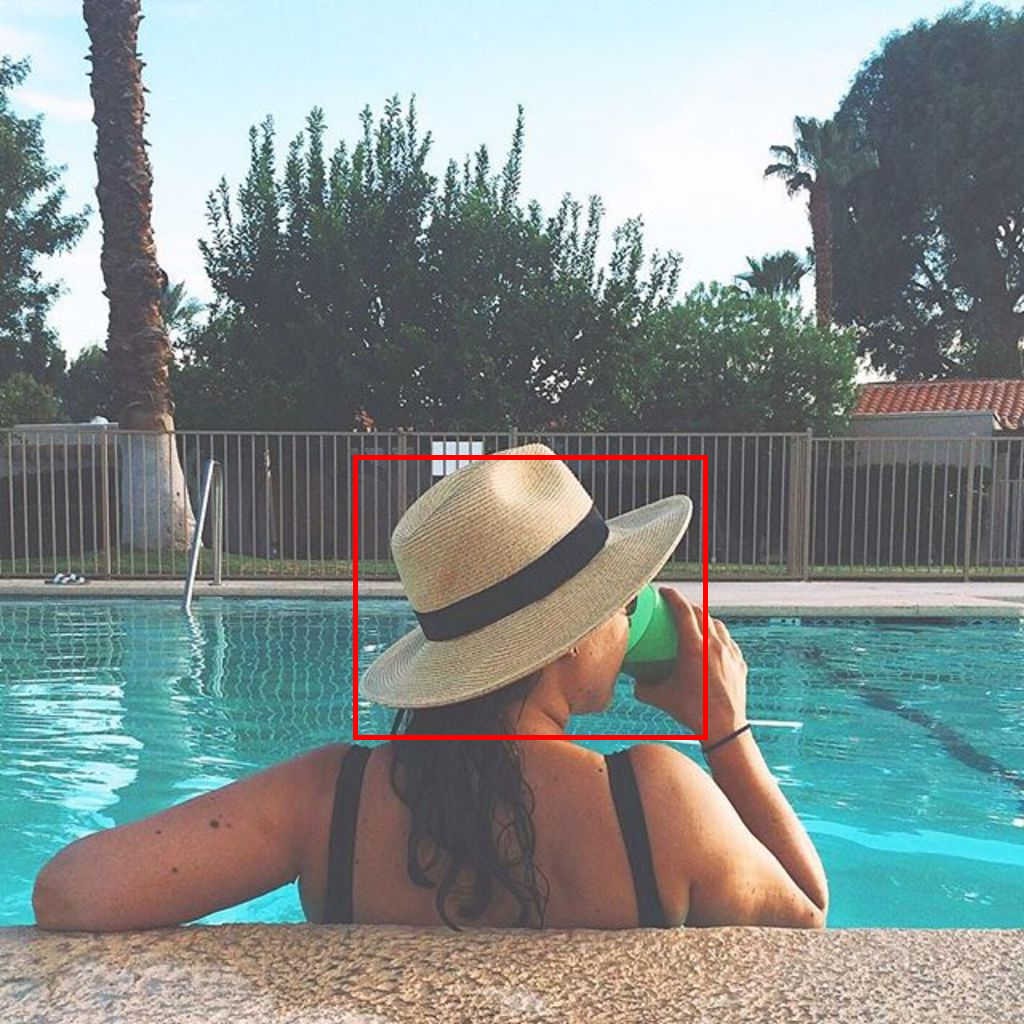

In [5]:
files = os.listdir('download/fedora/images')
random_file = random.choice(files)
show_bbox('download/fedora/images/' + random_file)

### Now, let's prepare our training data structure

In [6]:
# Create a folder structure for YOLOv5 training
if not os.path.exists('data'):
    for folder in ['images', 'labels']:
        for split in ['train', 'val', 'test']:
            os.makedirs(f'data/{folder}/{split}')

### As all images will end up in the same folder, we must check for duplicate images (an image can contain multiple classes).

In [7]:
import glob

def get_filenames(folder):
    filenames = set()

    for path in glob.glob(os.path.join(folder, '*.jpg')):
        # Extract the filename
        filename = os.path.split(path)[-1]
        filenames.add(filename)

    return filenames


# classes filename sets
fedora_images = get_filenames('download/fedora/images')


### We can now randomly split all our images in train/val/test

We will use here a standard split scheme: 0.75, 0.125, 0.125

In [8]:
import numpy as np

fedora_images = np.array(list(fedora_images))

# Use the same random seed for reproducability
np.random.seed(42)
np.random.shuffle(fedora_images)

In [9]:
import shutil
import math


def split_dataset(item, image_names, train_size, val_size):
    for i, image_name in enumerate(image_names):
        # Label filename
        label_name = image_name.replace('.jpg', '.txt')

        # Split into train, val, or test
        if i < train_size:
            split = 'train'
        elif i < train_size + val_size:
            split = 'val'
        else:
            split = 'test'

        # Source paths
        source_image_path = f'download/{item}/images/{image_name}'
        source_label_path = f'download/{item}/darknet/{label_name}'

        # Destination paths
        target_image_folder = f'data/images/{split}'
        target_label_folder = f'data/labels/{split}'

        # Copy files
        shutil.copy(source_image_path, target_image_folder)
        shutil.copy(source_label_path, target_label_folder)


train_ratio = 0.75
val_ratio = 0.125

# Bicycle data
fedora_images_train_size = math.floor(train_ratio * len(fedora_images))
fedora_images_val_size = math.floor(val_ratio * len(fedora_images))
split_dataset('fedora', fedora_images, train_size=fedora_images_train_size, val_size=fedora_images_val_size)

### Our dataset is now ready to use for training!